# NST for data augmentation

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import copy
from torch.utils.data import Subset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize



plt.ion()   # interactive mode

## Data load

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms_without_dataug = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), #Tenía 256 originalmente
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256), #Tenía 256 originalmente
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms_with_dataug = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'animalfaces'
data_dir_style='animalfacesV2'



def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

#Split no data aug
ds = ImageFolder(data_dir+'/train', transform=data_transforms_without_dataug['train'])
print(len(ds))
dss = train_val_dataset(ds)
dataloaders_wod = {x:DataLoader(dss[x],4, shuffle=True, num_workers=2) for x in ['train','val']}


# No data augmentation TEST
image_datasets_wod_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_without_dataug[x]) for x in ['test']}
dataloaders_wod_test = {x: torch.utils.data.DataLoader(image_datasets_wod_test[x], batch_size=4, shuffle=True, num_workers=2) for x in ['test']}



# Data augmentation
image_datasets_wd = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_with_dataug[x]) for x in ['train', 'test']}
image_datasets_wd['val'] = image_datasets_wd['test']
dataloaders_wd = {x: torch.utils.data.DataLoader(image_datasets_wd[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}


#style augmentation + data augmentation train/val split
dstiloso_wd = ImageFolder(data_dir_style+'/train', transform=data_transforms_with_dataug['train'])
dsstiloso_wd = train_val_dataset(dstiloso_wd)
dataloaders_st_wd = {x:DataLoader(dsstiloso_wd[x],4, shuffle=True, num_workers=2) for x in ['train','val']}


#style train/val split
dstiloso = ImageFolder(data_dir_style+'/train', transform=data_transforms_without_dataug['train'])
print(len(ds))
dsstiloso = train_val_dataset(dstiloso)
dataloaders_st = {x:DataLoader(dsstiloso[x],4, shuffle=True, num_workers=2) for x in ['train','val']}


# Style augmentation TEST
image_datasets_st_test = {x: datasets.ImageFolder(os.path.join(data_dir_style, x), data_transforms_without_dataug[x]) for x in ['test']}
dataloaders_st_test = {x: torch.utils.data.DataLoader(image_datasets_st_test[x], batch_size=4, shuffle=True, num_workers=2) for x in ['test']}


dataset_sizes_wod = {x: len(dss[x]) for x in ['train', 'val']}
dataset_sizes_wd = {x: len(image_datasets_wd[x]) for x in ['train', 'val']}
dataset_sizes_st = {x: len(dsstiloso[x]) for x in ['train', 'val']}
dataset_sizes_st_wd = {x: len(dsstiloso_wd[x]) for x in ['train', 'val']}
class_names = image_datasets_wd['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

7200
7200


## Visualization of examples of classes

Muestra de batch sin data augmentation tradicional


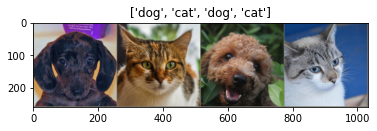

Muestra de batch con data augmentation tradicional


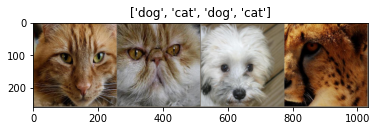

Muestra de batch con data style augmentation


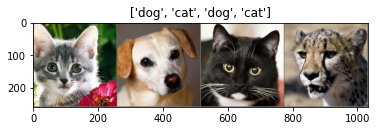

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders_wod['train']))
inputs_wd, classes_wd = next(iter(dataloaders_wd['train']))
inputs_st, classes_st = next(iter(dataloaders_st['train']))

# Make a grid from batch
out_wod = torchvision.utils.make_grid(inputs)
out_wd=torchvision.utils.make_grid(inputs_wd)
out_st=torchvision.utils.make_grid(inputs_st)

print("Muestra de batch sin data augmentation tradicional")
imshow(out_wod, title=[class_names[x] for x in classes])
print("Muestra de batch con data augmentation tradicional")
imshow(out_wd, title=[class_names[x] for x in classes])
print("Muestra de batch con data style augmentation")
imshow(out_st, title=[class_names[x] for x in classes])

## Training of the model

In [4]:
def train_model(model, dataloaders,datasize, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / datasize[phase]
            epoch_acc = running_corrects.double() / datasize[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Prediction visualization

In [5]:
def visualize_model(model, dataloaders, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Model definition

In [6]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Hyperparameters definition

In [77]:
#VGG19
#model_ft = models.vgg19(pretrained=False)
#model_ft.fc = nn.Linear(1000, len(class_names))


#Custom Net
model_ft=Net()

#Resnet
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, len(class_names))


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Training

In [78]:
model_ft = train_model(model_ft, dataloaders_st, dataset_sizes_st, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 1/5
----------
train Loss: 0.5883 Acc: 0.7480
val Loss: 0.3644 Acc: 0.8578

Epoch 2/5
----------
train Loss: 0.2293 Acc: 0.9178
val Loss: 0.2092 Acc: 0.9222

Epoch 3/5
----------
train Loss: 0.0823 Acc: 0.9719
val Loss: 0.3035 Acc: 0.9067

Epoch 4/5
----------
train Loss: 0.0443 Acc: 0.9839
val Loss: 0.1728 Acc: 0.9406

Epoch 5/5
----------
train Loss: 0.0377 Acc: 0.9883
val Loss: 0.1808 Acc: 0.9450

Training complete in 2m 17s
Best val Acc: 0.945000


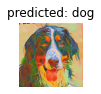

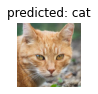

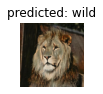

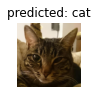

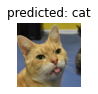

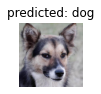

In [79]:
visualize_model(model_ft,dataloaders_st)

## Save trained model

In [113]:
#torch.save(model_ft, 'model_st_wd.pkl')
#torch.save(model_ft.state_dict(), 'params_st_wd.pkl')

## Load trained model

In [114]:
#model_1 = torch.load('model_st.pkl')
#model_2=torch.load('/content/model_st.pkl')
#model_1.load_state_dict(torch.load('params.pkl'))

## Test model with different test dataset

In [21]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

In [22]:
check_accuracy(dataloaders_wod_test['test'],model_ft)

Got 1320 / 1500 with accuracy 88.00


In [23]:
check_accuracy(dataloaders_st_test['test'],model_ft)

Got 1579 / 1800 with accuracy 87.72
